# Crossmatching NASA Exoplanet Archive data with Gaia DR3 using Gaia DR2 IDs

The Nasa Exoplanet Archive (NEA; https://exoplanetarchive.ipac.caltech.edu/) contains the most up to date information on exoplanet properties. We wish to crossmatch data in the NEA with the most recent data in the Gaia archive (https://gea.esac.esa.int/archive/), which as of 4/11/22 is DR3. The NEA contains Gaia IDs for the exoplanet host stars. However, as of 4/11/22, the NEA Gaia IDs are from Gaia DR2. Unfortunately, the Gaia IDs for the same stars are not neccessarily the same between different data releases. Therefore, we need to carefully crossmatch the Gaia DR2 IDs in the NEA with the correct Gaia DR3 stars.

The Gaia archive has a table called DR2_neighbourhood for crossmatching Gaia DR2 stars with DR3 stars, https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_auxiliary_tables/ssec_dm_dr2_neighbourhood.html. We want to use this table to assign Gaia DR3 IDs to all of the exoplanet host stars in the NEA. 

The goal of this script is to very carefully check this crossmatching to make sure that there are no problems, for example, non-unique matches between DR2 and DR3.

# Setup 

## Importing modules

In [1]:
import pandas as pd
import re
from astroquery.gaia import Gaia

## Downloading and reading in NEA data

We use the most up to date data from the NEA compositve planetary data: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PSCompPars. We download all the columns from the most recent data from the NEA compositve planetary catalogue as a csv, which produces a file with a name like, PSCompPars_2022.10.29_03.02.41.csv, where the numbers correspond to the date and time the data were downloaded. Something in the header of the csv file meant pandas could not read the data properly, so the quick work around is to remove all the extraneous header info (all rows starting with #).

In [2]:
# Read in the data using pandas
exoplanets = pd.read_csv("PSCompPars_2022.11.04_06.46.09.csv") # all extraneous header info (lines @beginning of file starting with #) removed so no need to skiprows
# exoplanets

## Extracting Gaia DR2 ID number

The variable containing the Gaia DR2 ID number in the NEA file, 'gaia_id', is a string with the following format: 'Gaia DR2 NNNNNN...'. The integer 'NN..NN' is the unique Gaia DR2 ID that we want to extract.

In [3]:
gaia_id_number = pd.DataFrame(exoplanets['gaia_id'].str.split(expand=True)[2]) # Extracting Gaia ID by splitting the string into components and selecting the final part
gaia_id_number.columns=['gaia_id_number']                                      # Giving the newly created Series a column name
gaia_id_number

,gaia_id_number
0,3946945413106333696
1,1696798367260229376
2,1920113512486282240
3,1385293808145621504
4,2135550755683407232
...,...
5192,348020448377061376
5193,348020448377061376
5194,348020448377061376
5195,3794167001116433152


## Removing rows with no Gaia DR2 IDs

For some reason, there are a small number of exoplanet host stars in the NEA which do not have a Gaia DR2 ID. Further work is needed to determine why this is the case, and ideally, to manually assign these exoplanet host stars a Gaia DR2 ID. For the purposes of testing the DR2/DR3 crossmatching, we make the decision to drop these exoplanet host stars without Gaia DR2 IDs.

In [4]:
# Determining the number of exoplanet host stars with no Gaia DR2 IDs
gaia_id_number.isnull().sum()    # As of 4/11/22 there are 202 out of 5197 entries in the composite NEA with no Gaia DR IDs

gaia_id_number    202
dtype: int64

In [5]:
# Dropping rows with no Gaia DR2 IDs and outputting as a new CSV file
# gaia_id_number.dropna().to_csv("PSCompPars_2022.11.04_06.46.09_gaia_id_number.csv", index=False)
gaia_id_number_dropna = gaia_id_number.dropna()
gaia_id_number_dropna

,gaia_id_number
0,3946945413106333696
1,1696798367260229376
2,1920113512486282240
3,1385293808145621504
4,2135550755683407232
...,...
5192,348020448377061376
5193,348020448377061376
5194,348020448377061376
5195,3794167001116433152


## Removing duplicate exoplanet host stars

Each row of the NEA table contains information about a single exoplanet. For systems with multiple planets around a star, this will lead to duplicates of the Gaia ID in different rows. We only need to match the exoplanet host star between Gaia DR2 and DR3 once, so we drop duplicates of the Gaia DR2 ID.

In [6]:
gaia_id_number_dropna_unique = gaia_id_number_dropna.drop_duplicates()

In [8]:
gaia_id_number_dropna_unique

,gaia_id_number
0,3946945413106333696
1,1696798367260229376
2,1920113512486282240
3,1385293808145621504
4,2135550755683407232
...,...
5187,2452378776434276992
5191,886479673643096448
5192,348020448377061376
5195,3794167001116433152


In [9]:
# Outputting as a CSV to read into Gaia archive
gaia_id_number_dropna_unique.to_csv("PSCompPars_2022.11.04_06.46.09_gaia_id_number_dropna_unique.csv", index=False)

# Crossmatching DR2 and DR3 in Gaia Archive

Now we have created the CSV file containing the Gaia DR2 IDs we need to load this file into the Gaia archive and run an SQL query to match using the appropriate Gaia table. It is possible to do this interactively on the Gaia website. However, for the sake of repeatability we prefer to automate this using a script to query the archive.

## Login to Gaia Archive

In [10]:
#### We can log onto the Gaia archive using the following formats:
#### Gaia.login_gui() - will display window to provide a username and password
#### Gaia.login() - a prompt will ask the user for name and password
#### Gaia.login(user=[username], password=[password]) - just type the username and password in the given fields
#### Gaia.login(credentials_file=[filename] - A path to the file that contains username and password. The username and password must be in different lines!

In [11]:
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]


User:  slongmor
Password:  ·········


OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


## Creating input query variables

In [19]:
input_csv_filename = "PSCompPars_2022.11.04_06.46.09_gaia_id_number_dropna_unique.csv"
input_table_name = "gaia_NEA_dr2_IDs"
input_id_column_name = "gaia_id_number"

username = "slongmor"
gaia_dr2_dr3_crossmatch_table = "gaiadr3.dr2_neighbourhood"

magnitude_difference = "0.1"

crossmatch_output_filename = "gaiadr3.dr2_neighbourhood_matchout.csv"

## Upload the Gaia DR2 IDs to the Gaia archive

Now we need to upload the csv file we created above with Gaia DR2 ID's to the Gaia archive. Note: the Gaia archive will not let you upload a table with the same name twice. Each table you upload must have a unique name. Also, note that the name given to the table within the Gaia archive using the variable 'table_name' cannot have any unusual characters like ".". If a table with that name already exists, you can remove the table using the "delete_user_table" function.

In [20]:
Gaia.delete_user_table(input_table_name)

Table 'gaia_NEA_dr2_IDs' deleted.


In [21]:
# Upload the table assuming the table name is unique
Gaia.upload_table(upload_resource=input_csv_filename, table_name=input_table_name, format="CSV")

Sending file: PSCompPars_2022.11.04_06.46.09_gaia_id_number_dropna_unique.csv
Uploaded table 'gaia_NEA_dr2_IDs'.


## Submit crossmatch query

In [22]:
# Creating the SQL query based on the variables above
query = f"""
SELECT dr2_names.*, both_names.*
FROM user_{username}.{input_table_name} AS dr2_names
JOIN {gaia_dr2_dr3_crossmatch_table} as both_names 
    ON both_names.dr2_source_id = dr2_names.{input_id_column_name}
WHERE ABS(magnitude_difference) < {magnitude_difference}
"""

In [23]:
#print(query)

In [25]:
# Running the query and outputting the result to the specified file
Gaia.launch_job_async(query).get_results().to_pandas().to_csv(f"{crossmatch_output_filename}", index=False)

INFO: Query finished. [astroquery.utils.tap.core]


# Inspect crossmatch output

In [31]:
# Reading in cross match
crossmatch = pd.read_csv(crossmatch_output_filename)

## Comparing number of returned matches

In [32]:
crossmatch

,gaia_nea_dr2_ids_oid,gaia_id_number,dr2_source_id,dr3_source_id,angular_distance,magnitude_difference,proper_motion_propagation
0,1,3946945413106333696,3946945413106333696,3946945413106333696,0.171659,0.064815,True
1,2,1696798367260229376,1696798367260229376,1696798367260229376,0.272179,0.056798,True
2,3,1920113512486282240,1920113512486282240,1920113512486282240,0.190454,0.050376,True
3,4,1385293808145621504,1385293808145621504,1385293808145621504,0.085541,0.015930,True
4,5,2135550755683407232,2135550755683407232,2135550755683407232,0.208378,0.016607,True
...,...,...,...,...,...,...,...
3651,3698,1244571953471006720,1244571953471006720,1244571953471006720,0.497859,0.061234,True
3652,3700,886479673643096448,886479673643096448,886479673643853952,1.306490,0.066464,True
3653,3701,348020448377061376,348020448377061376,348020482735930112,0.904173,0.067670,True
3654,3702,3794167001116433152,3794167001116433152,3794167001116704000,0.252776,0.093633,True


The crossmatch only returned 3656 sources out of the 3703 sources that were input.

In [33]:
crossmatch['dr2_source_id'].nunique()

3656

In [34]:
crossmatch['dr3_source_id'].nunique()

3656

## Inspecting the magnitude difference distribution

<AxesSubplot:>

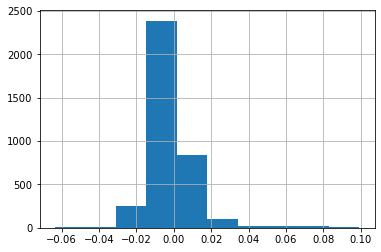

In [28]:
crossmatch['magnitude_difference'].hist()

<AxesSubplot:>

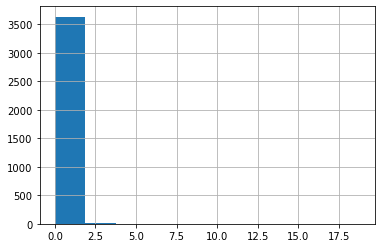

In [29]:
crossmatch['angular_distance'].hist()